In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys


sys.path.insert(1, "./../util")
sys.path.insert(1, "./../model")
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, EncodedProteinDataset_aux, collate_fn_new#, dynamic_collate_fn
from pseudolikelihood import get_npll2, get_npll_indep, get_npll
import torch, torchvision
from torch.nn.utils import clip_grad_norm_
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
import scipy
from tqdm import tqdm
import pandas as pd
import csv
import time
from torch.utils.tensorboard import SummaryWriter

#import pytorch_warmup as warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR

##TURIN HPC
#sys.path.insert(1, "/Data/silva/esm/")

## EUROPA
#sys.path.insert(1, "/home/lucasilva/esm/")

##Lucas computer
sys.path.insert(1, "/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
from Bio import SeqIO
from dynamic_loader import dynamic_collate_fn, dynamic_cluster

from torch.nn.functional import softmax
from torch.distributions import Categorical


In [2]:
### IDEA: MSAS PROCEDURE CAN GIVE DIFFERENT OUTPUT SHAPES? ASK
max_msas = 1
#msa_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/msas/"
msa_dir = "/home/luchinoprince/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings"

train_dataset = EncodedProteinDataset_aux(os.path.join(msa_dir, 'train'), encoding_dir, noise=0.02, max_msas=max_msas)          ## Default value of noise used


batch_structure_size = 1   ### I think with empty GPU we can go up to 16 easily
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 128 ### old is 32, original is 16
q = 21 ##isn't always 21
#dynamic_collate_fn

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True,
num_workers=1, pin_memory=True)




/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/tests/./../util/encoded_protein_dataset_new.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


In [7]:
decoder = None
embedding = None
torch.cuda.empty_cache()

seed = 24877
torch.random.manual_seed(seed)
np.random.seed(seed)



update_steps = 1000                                   ##Usual values are update steps=10^5, test_steps=10^2
bk_iter = False                                                  ## This tells us how ofter we save a model(default values is every ten-thousand updates)
#n_epochs = update_steps//(len(train_dataset)//batch_structure_size)   ## the other update steps will be used for "partial epochs", I want to save the last complet epoch
#print(f"With update_steps:{update_steps} we will do {n_epochs} full epochs")

input_encoding_dim = 512
param_embed_dim = 512
n_param_heads = 48
d_model = 512 ##old 512
n_heads = 8 ## old 8
n_layers = 6
## Check before running which is the GPU which is free the most and put it as the running device
device = 0        ## DON'T SET TO ONE OTHER THAN IN SPECIAL SPECIAL OCCASIONS, VERY NOISYYYYY!
dropout = 0.1

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.to(device)
embedding = get_embedding(q)
embedding.to(device)

Embedding(22, 21)

In [8]:
def get_loss_ardca(decoder, inputs, eta_J, eta_h):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder.forward_ardca(encodings, padding_mask)
    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)
    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta_J*(torch.sum(couplings**2))/B + eta_h*(torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 


def get_loss_loader_ardca(decoder, loader, eta_J, eta_h):
    decoder.eval()
    losses = []
    #with torch.no_grad():
    for effective_batch_size, inputs_packed in loader:
        npll_full = 0
        for inputs in inputs_packed:
            mini_batch_size = inputs[0].shape[0]
            #_, npll = get_loss_indep(decoder, inputs, eta_J, eta_h) ## For independent model without couplings
            _, npll = get_loss_ardca(decoder, inputs, eta_J, eta_h)
            npll_full += npll*mini_batch_size/effective_batch_size
        losses.append(npll_full)
            #del inputs
    
    return np.mean(losses)

def train_ardca(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler):
    effective_batch_size = inputs_packed[0]
    loss_penalty_full = 0
    train_loss_full = 0
    optimizer.zero_grad(set_to_none=True)                           ## set previous gradients to 0
    with torch.cuda.amp.autocast():  ## autocasting mixed precision
        for inputs in inputs_packed[1]:
            mini_batch_size = inputs[0].shape[0]
            #loss_penalty, train_batch_loss = get_loss_indep(decoder, inputs, eta_J, eta_h)    ## get the current loss for the batch this is for the independent training
            loss_penalty, train_batch_loss = get_loss_ardca(decoder, inputs, eta_J, eta_h)
            loss_penalty = loss_penalty * mini_batch_size/effective_batch_size
            train_batch_loss = train_batch_loss * mini_batch_size/effective_batch_size
            #loss_penalty.backward()                         ## Get gradients
            scaler.scale(loss_penalty).backward()
            loss_penalty_full += loss_penalty.detach()
            train_loss_full += train_batch_loss
    
    
    scaler.step(optimizer)
    scaler.update()
    #optimizer.step()   

    return loss_penalty_full, train_loss_full

In [9]:
## Let us also save the hyperparameters
#with summary_writer as w:
import warnings
warnings.filterwarnings("ignore")
lr = 1e-4
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)
eta_J = 1e-4
eta_h = 1e-4

start = time.time()
scaler = torch.cuda.amp.GradScaler()
with tqdm(total = update_steps) as pbar: ##This is used to have the nice loading bar while training
    train_loss = 0
    update_step = 0
    max_gpu=0
    train_batch_losses = []
    train_batch_losses_penalty = []
    epoch = 0.0
    while update_step < update_steps:
        for inputs_packed in train_loader:
            decoder.train()

            loss_penalty, train_batch_loss = train_ardca(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler)
            loss_penalty.detach()
            #optimizer.step()                                ## Do a step of GD
            update_step += 1                                ## Increase update step (the update steps will count also different batches within the same epoch)
            epoch = update_step / len(train_loader)
            
            train_batch_losses.append(train_batch_loss) ## Here we append the lossess in the different batches within the same epoch
            train_batch_losses_penalty.append(loss_penalty.item())

        
            pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f}  train: {train_loss:.2f}')
            pbar.update(1)
            
print(f"It took {time.time()-start} seconds")


update_step: 1000, epoch: 1000.00  train: 0.00: 100%|██████████| 1000/1000 [01:04<00:00, 15.55it/s]

It took 64.30714178085327 seconds


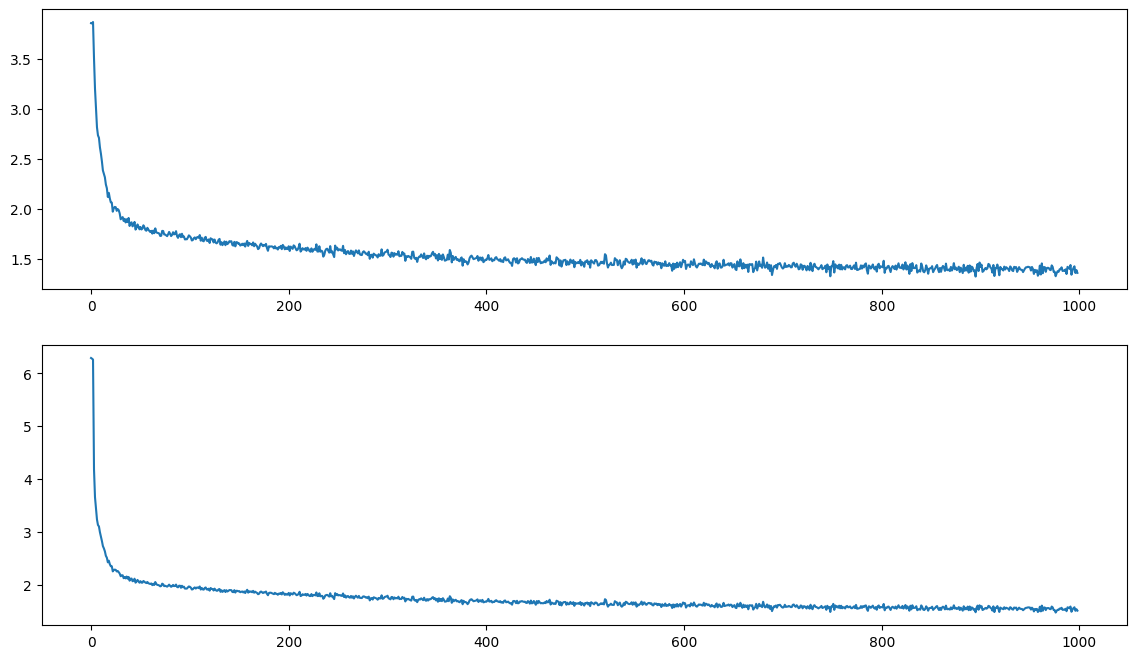

In [10]:
fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax1.plot(train_batch_losses[1:10000])
ax2.plot(train_batch_losses_penalty[1:10000])

In [11]:
train_dataset.msas_paths

['/home/luchinoprince/split2/train/2cq4A01_train.a3m.pt']

In [12]:
train_msa=torch.load(train_dataset.msas_paths[0]).to(torch.int)
train_msa

tensor([[20, 20, 20,  ..., 14,  2,  5],
        [20, 20, 20,  ..., 19, 15, 20],
        [20, 20, 20,  ..., 20, 20, 20],
        ...,
        [20, 20, 20,  ..., 20, 20, 20],
        [20, 20, 12,  ..., 20, 20, 20],
        [20, 20, 20,  ..., 20, 20, 20]], dtype=torch.int32)

In [13]:
decoder.eval()

for inputs_packed in train_loader:
    for inputs in inputs_packed[1]:
        msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
        B, M, N = msas.shape
        #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
        couplings, fields = decoder(encodings, padding_mask)


In [14]:
def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs